In the following notebook, I will be building a car price predictor using multiple linear regression.

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import yaml
import os

**Set Notebook Preferences**

In [2]:
#Set pandas preferences
pd.set_option('display.max_columns', 100)

#Set visualization preferences
plt.style.use('ggplot')

fontdict= {'title_fontsize':16,
           'label_fontsize':12}

**Read-in Data**

In [3]:
#Change directory to my_config.yaml
os.chdir('C:/Users/kishe/Documents/Data Science/Projects/Python/In Progress/Car_Price_Prediction')

#Read yaml file
from box import Box

with open('my_config.yaml') as file:
    yaml_data= Box(yaml.safe_load(file))

#Read in processed data
processed_data= pd.read_csv(yaml_data.base.path.processed_data, index_col=0,
                           dtype= {'symboling':'category'})

**Preview Data**

In [4]:
#Display head and data shape
print('Data shape:', processed_data.shape)
display(processed_data.head())

Data shape: (205, 24)


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,0,gas,std,two,sedan,rwd,front,102.0,191.7,70.6,47.8,3950,ohcv,twelve,326,mpfi,3.54,2.76,11.5,262,5000,13,17,36000.0
1,0,gas,std,four,sedan,rwd,front,120.9,208.1,71.7,56.7,3900,ohcv,eight,308,mpfi,3.80,3.35,8.0,184,4500,14,16,40960.0
2,1,gas,std,two,hardtop,rwd,front,112.0,199.2,72.0,55.4,3715,ohcv,eight,304,mpfi,3.80,3.35,8.0,184,4500,14,16,45400.0
3,0,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,52.8,4066,dohc,six,258,mpfi,3.63,4.17,8.1,176,4750,15,19,32250.0
4,0,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,52.8,4066,dohc,six,258,mpfi,3.63,4.17,8.1,176,4750,15,19,35550.0


**Check Info**

In [5]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   symboling         205 non-null    category
 1   fueltype          205 non-null    object  
 2   aspiration        205 non-null    object  
 3   doornumber        205 non-null    object  
 4   carbody           205 non-null    object  
 5   drivewheel        205 non-null    object  
 6   enginelocation    205 non-null    object  
 7   wheelbase         205 non-null    float64 
 8   carlength         205 non-null    float64 
 9   carwidth          205 non-null    float64 
 10  carheight         205 non-null    float64 
 11  curbweight        205 non-null    int64   
 12  enginetype        205 non-null    object  
 13  cylindernumber    205 non-null    object  
 14  enginesize        205 non-null    int64   
 15  fuelsystem        205 non-null    object  
 16  boreratio         205 non-

# Supervised Learning
## Base Model

**Import libraries**

In [6]:
#Import sklearn libaries
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_predict

#Import py files
from src.Models.machine_learning import regression_metrics

**Prepare data**

In [7]:
#Split data into X, y
X= processed_data.drop('price', axis = 1)
y= processed_data['price']

#Check shapes
print("Training data shape:%s\nTest data shape:%s" %(X.shape,y.shape))

Training data shape:(205, 23)
Test data shape:(205,)


In [8]:
#Subset numeric and categorical features
num_features= list(X.select_dtypes(include= ['float64', 'int64']).columns)
cat_features= list(X.select_dtypes(exclude= ['float64', 'int64']).columns)

**Build Pipeline**

In [9]:
#Create transformers
num_transformer= Pipeline(steps= [('scaler', StandardScaler())])
cat_transformer= Pipeline(steps= [('encoder', OneHotEncoder(handle_unknown='ignore'))])

#Init preprocessor with transformers
preprocessor= ColumnTransformer(transformers=[('numerics', num_transformer, num_features),
                                              ('categoricals', cat_transformer, cat_features)])

#Append preprocessor to pipeline
pipe= Pipeline(steps= [('preprocessor', preprocessor),
                                 ('regressor', LinearRegression(n_jobs=-1))
                                ])

**Test Base Model**

In [10]:
#Import scoring module
from src.Models.machine_learning import regression_metrics

#Run base_regressor and get predictions
BaseRegressorPredictions= cross_val_predict(estimator= pipe, X= X, y= y, 
                                            cv=5, n_jobs= -1)

In [11]:
#Create dictionary containing BaseRegressorPredictions and y
BaseRegressorDict= {'Predictions': BaseRegressorPredictions,
                   'Actual': list(y)}

#Convert dictionary into dataframe 
BaseRegressorResids= pd.DataFrame(data=BaseRegressorDict, columns= ['Predictions', 'Actual'])

#Read in lambda variable from boxcox transformation done in preprocessing file
lmbda= yaml_data.base.xglobal.lmbda

#Create dataframe BaseRegressorResids to store actual and predictions. Inverse boxcox. Calculate residuals
BaseRegressorResids= pd.DataFrame(data=BaseRegressorDict, columns= ['Predictions', 'Actual'])

# from scipy.special import inv_boxcox
# BaseRegressorResids = BaseRegressorResids.apply(lambda x: inv_boxcox(x, lmbda))
BaseRegressorResids['Residuals']= BaseRegressorResids['Actual']- BaseRegressorResids['Predictions']

#Check
display(BaseRegressorResids.head())

,Predictions,Actual,Residuals
0,27440.236942,36000.0,8559.763058
1,26835.928625,40960.0,14124.071375
2,22162.057503,45400.0,23237.942497
3,25982.603765,32250.0,6267.396235
4,25982.603765,35550.0,9567.396235


**Evaluate Base Model Performance and Errors**

{'MAE': 3339.1044381020274,
 'MAPE': 25.01248093600153,
 'MSE': 24809327.79125473,
 'RMSE': 4980.8962839287,
 'R2': 0.6093661233003144}

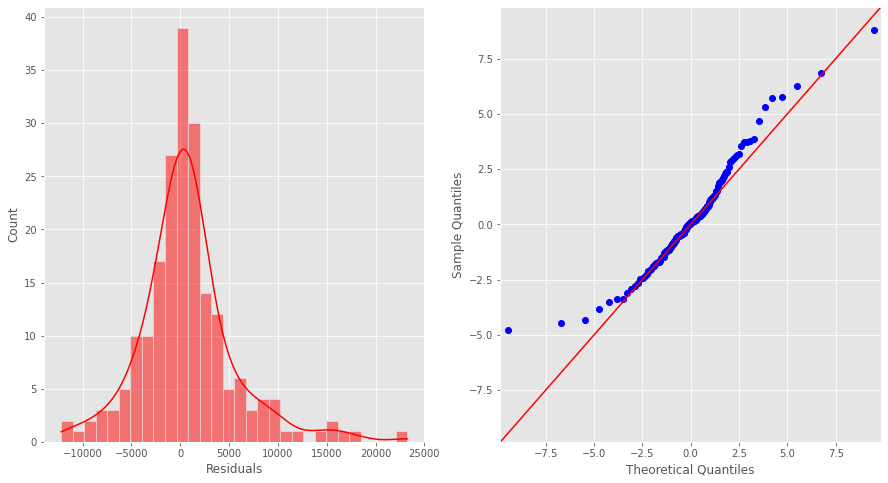

In [12]:
#Import visualization module
from src.Visualization.visualize import EDA_Viz

#Display model performance
BaseModelStats= regression_metrics(BaseRegressorResids.Predictions.values, BaseRegressorResids.Actual.values)
display(BaseModelStats)


#Init EDA_Viz object
BRResidsViz= EDA_Viz(BaseRegressorResids)

#Create figure
f, ax= plt.subplots(1,2, figsize= (15,8))

#Add residual plots to fig
BRResidsViz.histogram(feature= 'Residuals', ax= ax[0])
BRResidsViz.qqplot('Residuals', ax= ax[1]);

## Model 2.0 - Apply L2 Regularization 

**Update pipeline and add L2 regressor**

In [13]:
#Import l2
from sklearn.linear_model import Ridge

#Update pipeline
pipe.steps.pop(1)

#Add ridge regression to pipe
pipe.steps.append(['regressor', Ridge(alpha=1.0, random_state= 24)])

#Check
display(pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerics',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['wheelbase', 'carlength',
                                                   'carwidth', 'carheight',
                                                   'curbweight', 'enginesize',
                                                   'boreratio', 'stroke',
                                                   'compressionratio',
                                                   'horsepower', 'peakrpm',
                                                   'citympg', 'highwaympg']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('encoder',
                                                                 

In [14]:
#Fit updated pipe to data
Model2Predictions= cross_val_predict(estimator= pipe, X= X, y= y, 
                                            cv=5, n_jobs= -1)

**Evaluate Model 2.0 Performance**

In [15]:
#Create dictionary containing BaseRegressorPredictions and y
Model2Dict= {'Predictions': Model2Predictions,
                   'Actual': list(y)}

#Convert dictionary into dataframe 
Model2Resids= pd.DataFrame(data=Model2Dict, columns= ['Predictions', 'Actual'])

#Invert boxcox transformation
Model2Resids['Residuals']= Model2Resids['Actual']- Model2Resids['Predictions']

#Check
display(Model2Resids.head())

,Predictions,Actual,Residuals
0,29073.335230,36000.0,6926.664770
1,26677.999324,40960.0,14282.000676
2,22992.922685,45400.0,22407.077315
3,24823.134696,32250.0,7426.865304
4,24823.134696,35550.0,10726.865304


{'MAE': 3028.7398024098566,
 'MAPE': 22.535702307971654,
 'MSE': 21041322.567947943,
 'RMSE': 4587.08214096368,
 'R2': 0.6686950378194672}

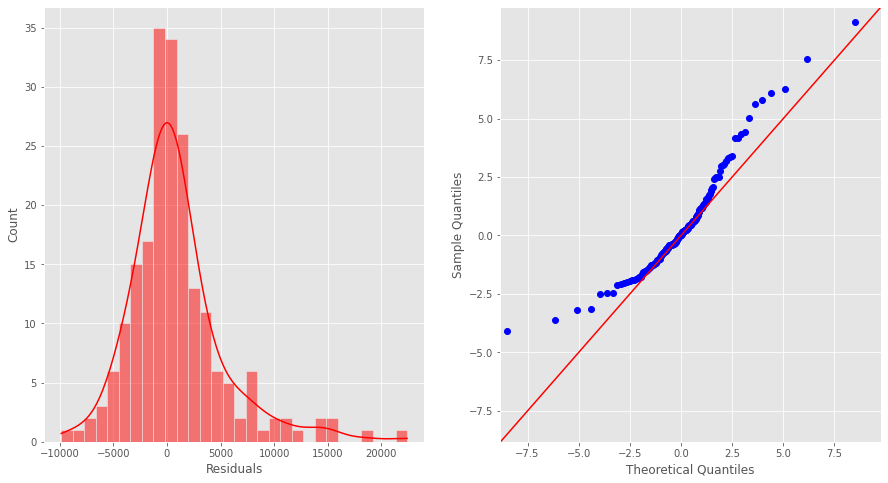

In [16]:
#Score model2.0
Model2Metrics= regression_metrics(Model2Resids.Predictions.values, Model2Resids.Actual.values)
display(Model2Metrics)

#Init EDA_Viz object
Model2ResidsViz= EDA_Viz(Model2Resids)

#Create figure
f, ax= plt.subplots(1,2, figsize= (15,8))

#Add residual plots to fig
Model2ResidsViz.histogram(feature= 'Residuals', ax= ax[0])
Model2ResidsViz.qqplot('Residuals', ax= ax[1]);

## Model 3.0 Apply Recursive Feature Elimination

In [17]:
#Import RFE
from sklearn.feature_selection import RFE

#Delete last step of pipeline
pipe.steps.pop(1)

#Update pipe with RFE
est= Ridge(alpha=1.0, random_state= 24)
pipe.steps.append( ['selector', RFE(est, n_features_to_select=5)])

In [18]:
#Get predictions and store as Model3Predictions
Model3Predictions= cross_val_predict(pipe, X= X, y= y, cv=5, n_jobs= -1)

#Create dictionary of predictions and actual values
Model3Dict= {'Predictions': Model3Predictions,
            'Actual': list(y)}

#Create a dataframe to store predictions and actual values
Model3Resids= pd.DataFrame(data= Model3Dict, columns=['Predictions', 'Actual'])

#Calculate Rediduals
Model3Resids['Residuals']= Model3Resids['Actual']- Model3Resids['Predictions']

#Check
Model3Resids

,Predictions,Actual,Residuals
0,26835.603085,36000.0,9164.396915
1,26399.648621,40960.0,14560.351379
2,24786.617103,45400.0,20613.382897
3,27847.017442,32250.0,4402.982558
4,27847.017442,35550.0,7702.982558
...,...,...,...
200,5282.871207,5399.0,116.128793
201,8149.066510,10945.0,2795.933490
202,8149.066510,11845.0,3695.933490
203,8149.066510,13645.0,5495.933490


**Evaluate Pipeline**

{'MAE': 3028.7398024098566,
 'MAPE': 22.535702307971654,
 'MSE': 21041322.567947943,
 'RMSE': 4587.08214096368,
 'R2': 0.6686950378194672}

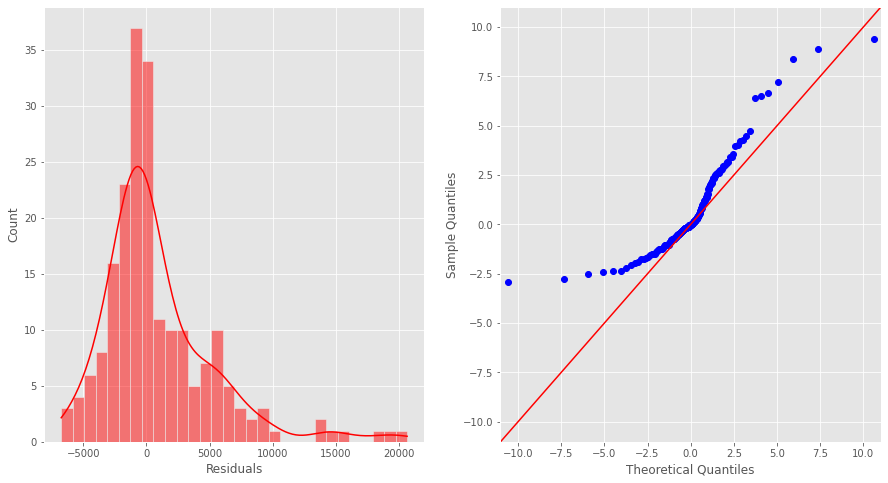

In [19]:
#Get and display metrics
Model3Metrics= regression_metrics(Model3Resids.Predictions.values, Model3Resids.Actual.values)
display(Model2Metrics)

#Init EDA_Viz object
Model3ResidsViz= EDA_Viz(Model3Resids)

#Create figure
f, ax= plt.subplots(1,2, figsize= (15,8))

#Add residual plots to fig
Model3ResidsViz.histogram(feature= 'Residuals', ax= ax[0])
Model3ResidsViz.qqplot('Residuals', ax= ax[1]);